# **Introduction**

#### **The dataset consists the stock price value of Netflix 2018 to 2022. The aim of this project is to predict the price as well to forecast the stock prices for next 30 days**

#### **Link to dataset: https://drive.google.com/file/d/1xKxL0GOiE8H9XaoqrJQdbqjyVFvu_HTb/view?usp=sharing**

# **Step 1 - Importing the libraries**

#### **Configuration Libraries**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#### **Classical Libraries**

In [ ]:
import numpy as np #numerical python
import pandas as pd #data manipulation
import seaborn as sns  #visual
import matplotlib.pyplot as plt #visual
plt.style.use("dark_background") #theme

#### **Machine Learning Libraries**

In [ ]:
from tqdm import tqdm
from scipy import stats
from prophet import Prophet
import statsmodels.api as sm
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# **Step 2 - Data Loading**

#### **Data Loading**

In [ ]:
df = pd.read_csv("/content/NFLX.csv")

#### **Data Inspection**

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200
1008,2022-02-04,407.309998,412.769989,396.640015,410.170013,410.170013,7782400


<hr>

# **Step 3 - Objectives to be followed**

### **Fundamental Analysis**
  **This is the analysis that involves assessing the company's potential profitability by analyzing the current business environment and financial performance**

### **Technical Analysis**

  **This process involves studying the graphs and using the statistical data to understand and identify the patterns and trends in the stocks**


  **`For this particular project, we would focusing more on to the technical part of the analysis`**

### **Dataset Content**
  * **`Target`: The calculation of profit and loss is typically based on the closing price for the stock on a day. Therefore for the analysis purpose we will considering the `Adj Close` as target variable**
  * **`Open and Close`: These are the prices of the stock at the start and the end of the day**
  * **`Volume`: The number of shares that has been traded in a day**

### **Removing all the other columns**
  **Since, we are aware that most of the problems are going to be solved using the `Adj Close` column, hence we will be dropping the other column rather than `Date`.**

In [ ]:
df = df.drop(["Open", "High", "Low", "Close", "Volume"], axis = 1)

In [ ]:
df.head()

,Date,Adj Close
0,2018-02-05,254.259995
1,2018-02-06,265.720001
2,2018-02-07,264.559998
3,2018-02-08,250.100006
4,2018-02-09,249.470001


<hr>

# **Step 4 - Technical Analysis**

### **Collect / Gather the data together**

In [ ]:
df = df.groupby("Date")["Adj Close"].sum().reset_index()


In [ ]:
df.tail()

,Adj Close
Date,
2022-01-31,427.140015
2022-02-01,457.130005
2022-02-02,429.480011
2022-02-03,405.600006
2022-02-04,410.170013


### **Convert the date column into datetime format**

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1009 non-null   datetime64[ns]
 1   Adj Close  1009 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.9 KB


### **Set the datetime column into index**

In [ ]:
df = df.set_index(["Date"])

In [ ]:
df.head()

,Adj Close
Date,
2018-02-05,254.259995
2018-02-06,265.720001
2018-02-07,264.559998
2018-02-08,250.100006
2018-02-09,249.470001


**We wanted to understand the behaviour of the target variable**

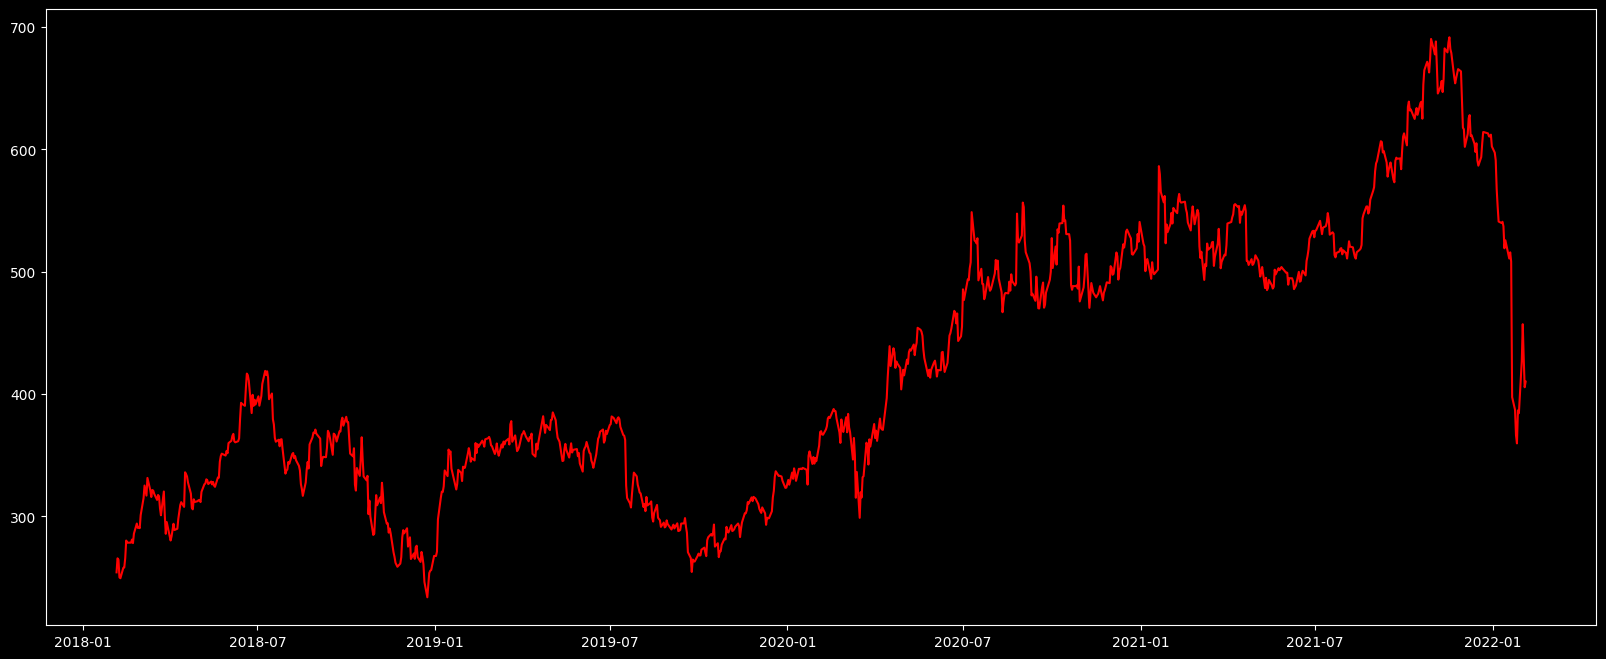

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(df, color = "red")
plt.show()

**Looking at the data, we can clearly say that after the year of 2020, we have got a very great upward trend and having a sharp decline in the recent date like Nov, 2021**

# **Step 5 - Check for stationarity**

#### **Implementing ADFuller**

In [ ]:
results = adfuller(df)

#### **Understanding the results**

In [ ]:
results

(-1.8125906878289955,
 0.3742289256820759,
 6,
 1002,
 {'1%': -3.436893045520188,
  '5%': -2.8644287878535146,
  '10%': -2.568308127138936},
 7545.926742057859)

In [ ]:
print(f"""ADF Stats: {results[0]}
      \nP-Value: {results[1]}
      \nLags Used: {results[2]}""")

ADF Stats: -1.8125906878289955
      
P-Value: 0.3742289256820759
      
Lags Used: 6


In [ ]:
if results[1] > 0.05:
  print("The data is not stationary")
else:
  print("The data is stationary")

The data is not stationary


# **Step 6 - Achieving Stationarity**

### **Differencing**

In [ ]:
diff1 = df - df.shift(1)

In [ ]:
diff1 = diff1.dropna()

### **Let's check again for stationarity**

In [ ]:
results = adfuller(diff1)

In [ ]:
if results[1] > 0.05:
  print("The data is not stationary")
else:
  print("The data is stationary")

The data is stationary


In [ ]:
print(f"""ADF Stats: {results[0]}
      \nP-Value: {results[1]}
      \nLags Used: {results[2]}""")

ADF Stats: -14.24227599292912
      
P-Value: 1.5304022754298515e-26
      
Lags Used: 5


### **Visualize the results**

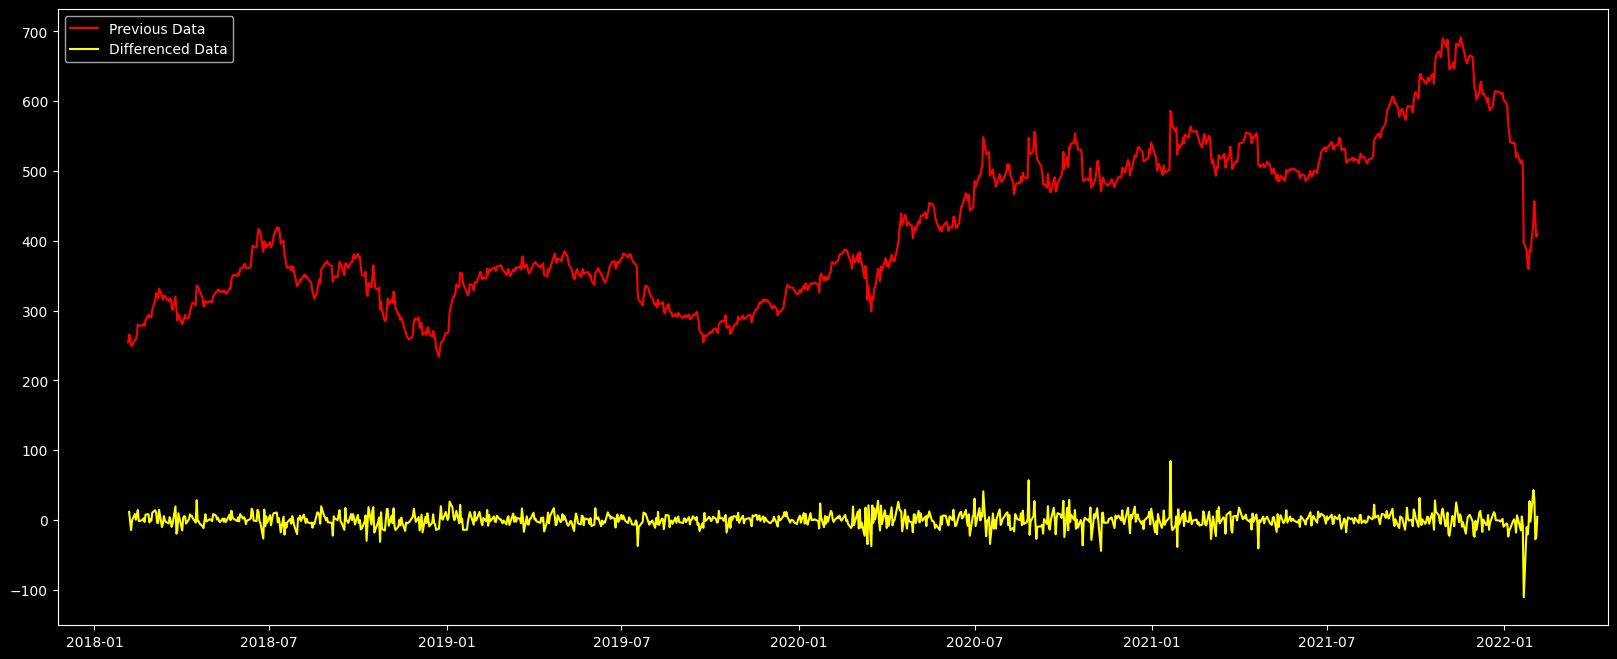

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(df, color = "red", label = "Previous Data")
plt.plot(diff1, color = "yellow", label = "Differenced Data")
plt.legend()
plt.show()

* **With reference to the previous data, we can easily observe that there was a lot of hinderance in the previous data, as we can clearly observe the change in the mean and variance over the period of time**
* **If we consider the new data (differenced data), we can clearly observe that the constant change is no more there in the data**

### **Seasonal Decomposition**

In [ ]:
decompose = seasonal_decompose(x = diff1, period = 30)

In [ ]:
trend = decompose.trend
seasonality = decompose.seasonal
noise = decompose.resid

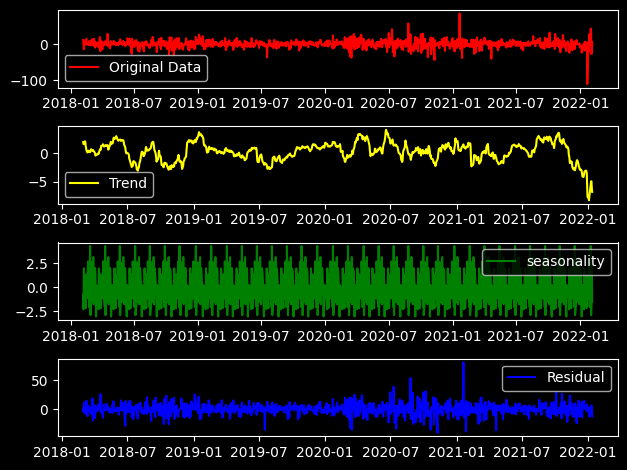

In [ ]:
plt.subplot(411)
plt.plot(diff1, label = 'Original Data', color = 'red')
plt.legend()

plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'yellow')
plt.legend()

plt.subplot(413)
plt.plot(seasonality, label = 'seasonality', color = 'green')
plt.legend()

plt.subplot(414)
plt.plot(noise, label = 'Residual', color = 'blue')
plt.legend()
plt.tight_layout()

# **Step 7 - Finding the orders of the model**

#### **ACF**

In [ ]:
diff1.columns

Index(['Adj Close'], dtype='object')

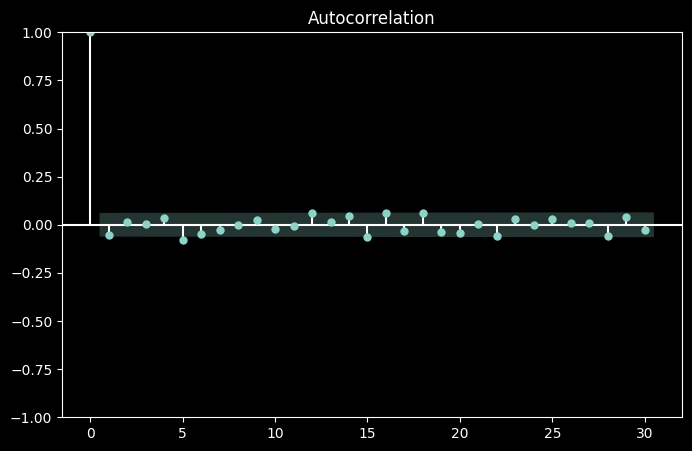

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(diff1["Adj Close"], ax = ax, lags = 30)
plt.show()

#### **PACF**

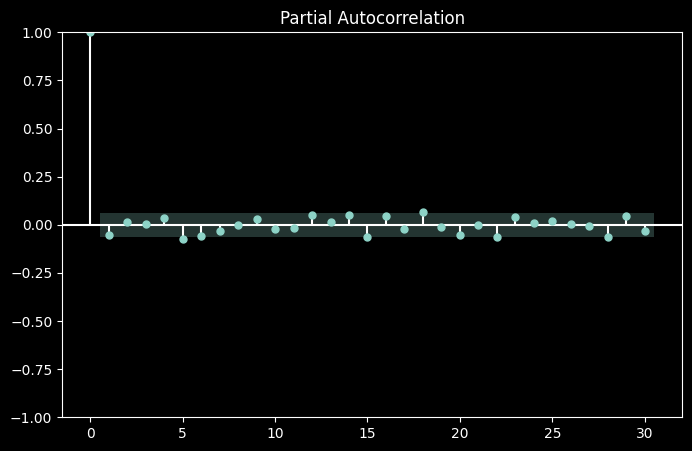

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(diff1["Adj Close"], ax = ax, lags = 30)
plt.show()

ACF &PACF

### **Itertools approach**

In [ ]:
# Defining the ranges for p, d and q
p = range(0, 8, 1)
d = 1
q = range(0, 8, 1)

In [ ]:
# Create a list that will store all the possible combination of these paramters
parameter_list = product(p, q)

In [ ]:
parameters = list(parameter_list)

In [ ]:
parameters

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7)]

In [ ]:
# Generate the perfect order of SARIMA
order_list = []

In [ ]:
# We will start evaluating each order one by one
for x in parameters:
  # Convert each combination into a list
  comb = list(x)
  # Insert the value of "d"
  comb.insert(1, d)
  # Convert each and every data back to tuple
  comb = tuple(comb)
  # Append the order in the final combination
  order_list.append(comb)

In [ ]:
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

<hr>

# **Step 8 - SARIMAX**

### **SARIMAX**

In [ ]:
def optimize_sarimax(data, order_list):
  # results variable
  results = []
  # For loop that will fit the model for all the order that we have created
  for x in tqdm(order_list, desc = "Fitting SARIMA Model"):
    try:
      model = SARIMAX(data, order = x, simple_differencing = False).fit(display = False)
    except:
      continue
    # This will help us to evaluate the error
    aic = model.aic
    results.append([x, aic])

  # Create a dataframe that will help us evaluate everything
  results_df = pd.DataFrame(results, columns = ["(P, D, Q)", "AIC"])
  # Sort the values
  results_df = results_df.sort_values(by = "AIC", ascending = True).reset_index(drop = True)

  return results_df

In [ ]:
10/0

ZeroDivisionError: division by zero

In [ ]:
results_df = optimize_sarimax(df["Adj Close"], order_list)

Fitting SARIMA Model: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it]


In [ ]:
results_df

,"(P, D, Q)",AIC
0,"(6, 1, 6)",7702.722774
1,"(5, 1, 5)",7702.787210
2,"(3, 1, 3)",7702.832772
3,"(3, 1, 2)",7702.973987
4,"(5, 1, 6)",7703.398883
...,...,...
59,"(6, 1, 4)",7711.087985
60,"(1, 1, 4)",7711.092966
61,"(4, 1, 2)",7711.215033
62,"(4, 1, 6)",7711.584312


####**Predictions**

In [ ]:
best_order = results_df.loc[0, "(P, D, Q)"]

model = SARIMAX(df["Adj Close"], order=best_order, simple_differencing=False).fit(disp=False)

forecast = model.get_forecast(steps=30)

predicted_values = forecast.predicted_mean

print(predicted_values)

1009    408.603822
1010    400.179374
1011    393.166354
1012    391.768230
1013    396.047945
1014    398.195215
1015    398.460530
1016    399.912785
1017    406.069384
1018    411.480072
1019    411.822233
1020    407.283751
1021    403.801981
1022    402.953014
1023    401.849564
1024    397.919795
1025    394.025416
1026    394.605042
1027    398.988595
1028    403.092388
1029    403.997304
1030    404.599176
1031    406.563883
1032    409.134056
1033    407.915085
1034    403.984647
1035    399.849844
1036    399.188864
1037    399.158203
1038    398.754460
Name: predicted_mean, dtype: float64


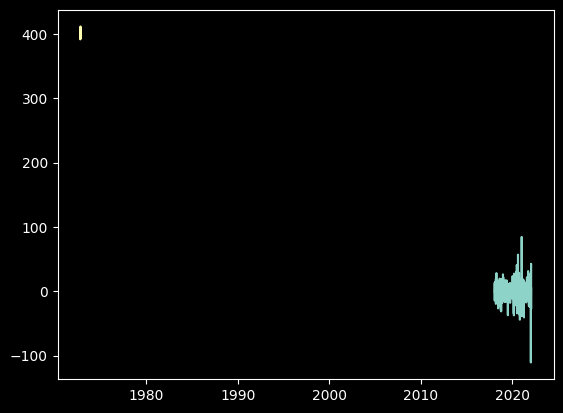

In [ ]:
plt.plot(diff1)
plt.plot(predicted_values)

In [ ]:
best_order

(6, 1, 6)

# **Step 9 - ARIMA**

### **Implementation**

In [ ]:
model = ARIMA(df["Adj Close"], order = best_order)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1009
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -3838.361
Date:                Sun, 22 Sep 2024   AIC                           7702.723
Time:                        17:02:43   BIC                           7766.627
Sample:                             0   HQIC                          7727.002
                               - 1009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2226      0.065      3.445      0.001       0.096       0.349
ar.L2          0.6265      0.062     10.131      0.000       0.505       0.748
ar.L3         -1.1327      0.069    -16.518      0.000      -1.267      -0.998
ar.L4          0.5390      0.062      8.658      0.000       0.417       0.661
ar.L5          0.2455      0.056      4.348      0.000       0.135       0.356
ar.L6         -0.8749      0.065    -13.535      0.000      -1.002      -0.748
ma.L1         -0.2625      0.074     -3.540      0.000      -0.408      -0.117
ma.L2         -0.5879      0.068     -8.668      0.000      -0.721      -0.455
ma.L3          1.1596      0.071     16.444      0.000       1.021       1.298
ma.L4         -0.5766      0.065     -8.882      0.000      -0.704      -0.449
ma.L5         -0.2654      0.065     -4.060      0.000      -0.394      -0.137
ma.L6          0.8397      0.073     11.528      0.000       0.697       0.982
sigma2       120.4552      2.382     50.562      0.000     115.786     125.125
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              9330.40
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### **Prediction**

In [ ]:
df["Prediction ARIMA"] = results.predict(start = 1, end = 1008)

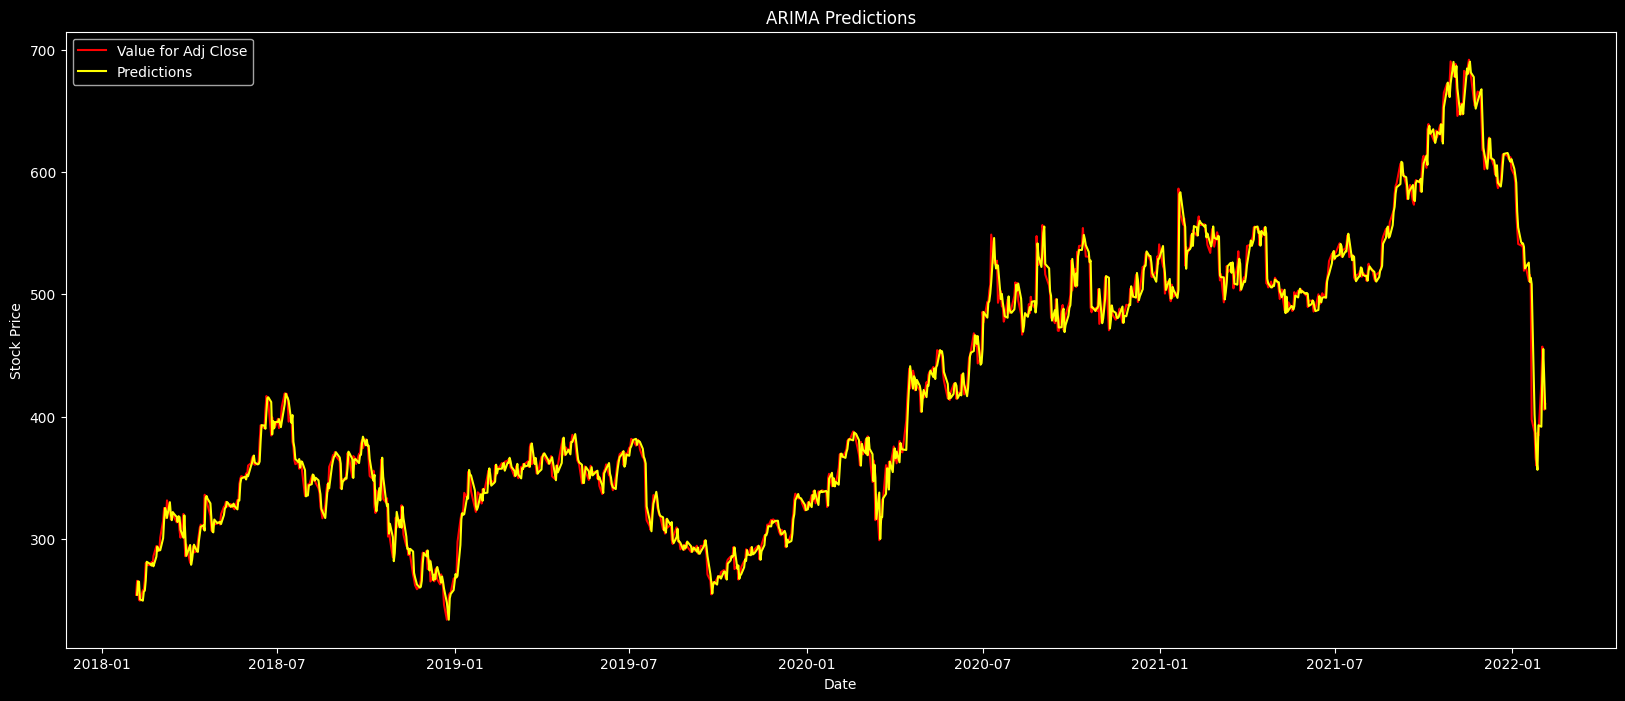

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(df["Adj Close"], color = "red", label = "Value for Adj Close")
plt.plot(df["Prediction ARIMA"], color = "yellow", label = "Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("ARIMA Predictions")
plt.legend()
plt.show()

In [ ]:
df.tail()

,Adj Close,Prediction ARIMA
Date,,
2022-01-31,427.140015,391.656473
2022-02-01,457.130005,431.383101
2022-02-02,429.480011,455.196725
2022-02-03,405.600006,430.327842
2022-02-04,410.170013,406.537187


# **Step 10 - Prophet**

### **Implementation**

In [ ]:
# Prepare your data for prophet
df_prophet = df.reset_index()

# Only two columns
df_prophet = df_prophet[["Date", "Adj Close"]]

In [ ]:
df_prophet.head()

,Date,Adj Close
0,2018-02-05,254.259995
1,2018-02-06,265.720001
2,2018-02-07,264.559998
3,2018-02-08,250.100006
4,2018-02-09,249.470001


**Prophet always accept the data into two particular columns: `ds` and `y`**

In [ ]:
df_prophet = df_prophet.rename(columns = {"Date": "ds", "Adj Close" : "y"})

#### **Model Building**

In [ ]:
model = Prophet()

In [ ]:
model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7bhbksnp/4yp6ne1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7bhbksnp/vxqf7d8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34867', 'data', 'file=/tmp/tmp7bhbksnp/4yp6ne1b.json', 'init=/tmp/tmp7bhbksnp/vxqf7d8f.json', 'output', 'file=/tmp/tmp7bhbksnp/prophet_modelhwjjy5f3/prophet_model-20240922170626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### **Prediction**

In [ ]:
future = model.make_future_dataframe(periods = 365)

In [ ]:
future

,ds
0,2018-02-05
1,2018-02-06
2,2018-02-07
3,2018-02-08
4,2018-02-09
...,...
1369,2023-01-31
1370,2023-02-01
1371,2023-02-02
1372,2023-02-03


##### **Generate the forecast**

In [ ]:
forecast = model.predict(future)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-02-05,294.110739,232.241855,324.884183,294.110739,294.110739,-15.144579,-15.144579,-15.144579,7.496002,7.496002,7.496002,-22.640581,-22.640581,-22.640581,0.0,0.0,0.0,278.966160
1,2018-02-06,294.376118,237.523697,327.737939,294.376118,294.376118,-10.517749,-10.517749,-10.517749,9.326390,9.326390,9.326390,-19.844139,-19.844139,-19.844139,0.0,0.0,0.0,283.858370
2,2018-02-07,294.641497,240.249270,332.627793,294.641497,294.641497,-8.452922,-8.452922,-8.452922,8.552164,8.552164,8.552164,-17.005086,-17.005086,-17.005086,0.0,0.0,0.0,286.188576
3,2018-02-08,294.906877,239.829441,335.053240,294.906877,294.906877,-5.474243,-5.474243,-5.474243,8.685565,8.685565,8.685565,-14.159809,-14.159809,-14.159809,0.0,0.0,0.0,289.432633
4,2018-02-09,295.172256,241.008189,339.552662,295.172256,295.172256,-4.669643,-4.669643,-4.669643,6.674557,6.674557,6.674557,-11.344200,-11.344200,-11.344200,0.0,0.0,0.0,290.502613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,2023-01-31,661.688170,548.420106,717.251396,590.403509,732.857727,-25.906270,-25.906270,-25.906270,9.326390,9.326390,9.326390,-35.232660,-35.232660,-35.232660,0.0,0.0,0.0,635.781901
1370,2023-02-01,661.897120,552.564240,722.274800,590.318396,733.516125,-24.674103,-24.674103,-24.674103,8.552164,8.552164,8.552164,-33.226267,-33.226267,-33.226267,0.0,0.0,0.0,637.223017
1371,2023-02-02,662.106070,551.262603,720.275939,590.278921,734.117954,-22.316888,-22.316888,-22.316888,8.685565,8.685565,8.685565,-31.002453,-31.002453,-31.002453,0.0,0.0,0.0,639.789182
1372,2023-02-03,662.315019,548.999464,729.050701,590.239446,734.852552,-21.915604,-21.915604,-21.915604,6.674557,6.674557,6.674557,-28.590161,-28.590161,-28.590161,0.0,0.0,0.0,640.399415


###### **Visualize**

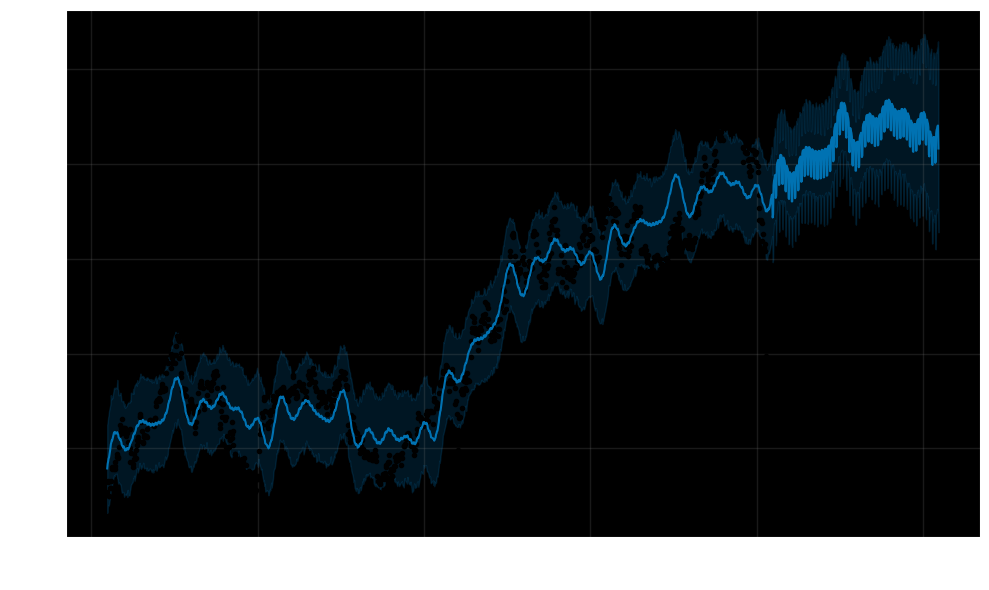

In [ ]:
model.plot(forecast)
plt.show()